## Customer Lifetime Value Analysis - Hopper

In [85]:
pd.set_option('display.max_columns', 100)
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
from lifetimes.plotting import plot_history_alive
from lifetimes import GammaGammaFitter

### Data Preprocessing

In [86]:
watch_df = pd.read_csv('search_sample_data/watch_sample.csv')
watch_df['status_latest'].value_counts()

shopped     797239
inactive    211847
expired     148724
booked        8764
active        1571
Name: status_latest, dtype: int64

In [87]:
booked_df = watch_df.loc[watch_df['status_latest'] == 'booked']
cols_of_interest = ['user_id', 'latest_status_change_dt', 'lowest_price']
booked_df = booked_df[cols_of_interest]
booked_df = booked_df[pd.notnull(booked_df['lowest_price'])]

booked_df['latest_status_change_dt'] = pd.to_datetime(booked_df['latest_status_change_dt'])
booked_df['latest_status_change_dt'] = booked_df['latest_status_change_dt'].dt.date
booked_df['latest_status_change_dt'] = pd.to_datetime(booked_df['latest_status_change_dt'])
booked_df['latest_status_change_dt'].min(), booked_df['latest_status_change_dt'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2019-09-17 00:00:00'))

In [88]:
booked_df['user_id'].nunique()

4596

In [89]:
booked_df.head(10)

,user_id,latest_status_change_dt,lowest_price
114,4a7ab9b3a1c10f8b7036e55605a758a5c7654e1682b057...,2018-05-02,391.0
338,21557c4bf83241450f6f23baf1c949fd8d5b13abc401cd...,2018-02-09,359.0
640,fe895b28195094b405b5d887c894e1b3cdde9945047baa...,2018-02-24,627.0
678,2929c98ea8d72bd251025ef1ff232ca9a3a38483c18fd4...,2018-05-06,267.0
725,c6a8984d9c1f975afe69bd162b242830bbb7310f4c9204...,2018-06-21,192.0
1361,83e2bb025505e996626e3fac10da0d16785c3e1bae1f1d...,2018-08-31,137.0
1364,92e9c28aeeaa9c19618d9c8ef77a48ff6079dd0ed0c36d...,2018-04-17,113.0
1512,9c5be29b757ce0e34685f630e3f2c9323a0ba3b9b96505...,2018-01-16,86.0
1619,eaf5f71b19d612441bb959593778fafe9b4ac1ad0fc486...,2018-07-19,194.0
1636,59b034a8d3b262d35e89b096c2cdac072e59a451bd022a...,2018-12-18,172.0


In [90]:
data = summary_data_from_transaction_data(booked_df, 'user_id', 'latest_status_change_dt', monetary_value_col='lowest_price', observation_period_end='2019-09-17')
data.head(10)

,frequency,recency,T,monetary_value
user_id,,,,
001a25f124e240f5372e8c73117c54bd1b1ae6339bf864100a9abd1ddafa49ff,1.0,39.0,275.0,602.0
0067a6541cc78bd52ba0b9a4216e7f0e27e6cf7c6847a6dbbaf8b53194c01943,0.0,0.0,556.0,0.0
00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc972b09da4c786dd69,3.0,268.0,455.0,459.0
00770c43298f4cd9ee3dfe37882825be327db3dca9affd9074639c9b1c9d7907,2.0,174.0,490.0,152.0
007de8bbd4f4dea2de20d00f3b904e08210d94a6215e0f57b1817711838a9b05,0.0,0.0,488.0,0.0
00874310e86ae74c1b470ec0f766493ed2f8949bbc004715d8e72bd70d97d1c7,1.0,5.0,602.0,412.0
00a143d91b4c16f3962dbbb4cbe76814c5fdd3104feecfb24d0ce46c1768cd54,0.0,0.0,575.0,0.0
00ad4737c47b868cb87f461d899c7a5720f8dd64aa8e1d3a821ef0859dc8b3ce,0.0,0.0,224.0,0.0
00c7f503021d4abdde4878c2b0caa9cfdcdc0c2cccd154ca174afedb66a152ad,0.0,0.0,578.0,0.0


In [91]:
booked_df.loc[booked_df['user_id'] == '00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc972b09da4c786dd69']

,user_id,latest_status_change_dt,lowest_price
610019,00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32b...,2019-03-14,628.0
692114,00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32b...,2019-02-22,79.0
749249,00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32b...,2018-06-19,707.0
886100,00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32b...,2019-02-22,151.0
1033859,00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32b...,2018-06-21,519.0


### Modeling

In [92]:
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4596 subjects, a: 5.72, alpha: 40.51, b: 8.89, r: 0.19>


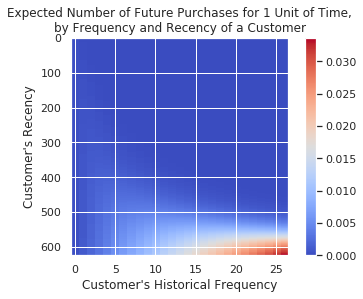

In [93]:
plot_frequency_recency_matrix(bgf);

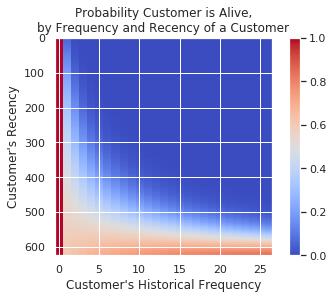

In [94]:
plot_probability_alive_matrix(bgf);

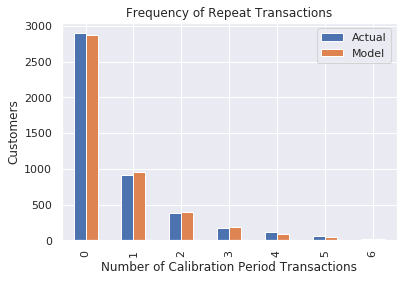

In [96]:
plot_period_transactions(bgf);

In [97]:
t = 180
data['predicted_bookings'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_bookings').tail(10)

,frequency,recency,T,monetary_value,predicted_bookings
user_id,,,,,
3b8991978a75d389403af0c972d743f7d1cbdae04b26e49c113c5b5fbb0599da,4.0,444.0,548.0,182.750000,0.491222
2c9ea1b97874e885e5ea9130776559c5e9c1a7797488e28579ce799c169b339d,4.0,505.0,582.0,197.750000,0.533625
2525229e228c56832d2a4cd3b6612edf22888529c89f946fddf02e97b88fd994,5.0,438.0,546.0,192.800000,0.543835
61cdba5bd36ef570795ec878cb8ca236249d159ea26c1e069a8f178a2cda3a42,3.0,151.0,230.0,72.333333,0.560153
53202866781272e3cfb8cb48f0c4741adbdc6451f28b86b4065093a11ad923d9,2.0,193.0,220.0,252.000000,0.630366
56860e4f56ad71d175ceaefc97b3b0ce2a535a8f4ce7e6d65077f92a56ee92ec,6.0,462.0,557.0,225.333333,0.644602
d6117c97f04949739dc01390875a0931c7ed9428d472b0f7e9ac3e52f516b503,7.0,508.0,607.0,185.857143,0.670566
c69a34889bae4eb4e726df1c8090528f6c477d581da6adcd8a709f09e4a203de,4.0,454.0,461.0,190.500000,0.769049
ff5d282e53a36a19446a9f5357fa41f3f9ba3a27d89d1419912c6da53f65db01,8.0,453.0,516.0,265.500000,0.965248


In [98]:
booked_df.loc[booked_df['user_id'] == 'd4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647a87b66b262972bb09c'].sort_values(by='latest_status_change_dt')

,user_id,latest_status_change_dt,lowest_price
93922,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-01-06,186.0
515474,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-01-22,237.0
755379,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-06-24,277.0
1053991,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-06-30,497.0
711220,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-07-07,560.0
116536,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-10-24,418.0
1005128,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-11-20,417.0
515472,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2018-12-02,86.0
1145203,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2019-02-04,482.0
428732,d4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647...,2019-06-21,614.0


In [99]:
data.sort_values(by='predicted_bookings').head(10)

,frequency,recency,T,monetary_value,predicted_bookings
user_id,,,,,
22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a70f128fc062c0d3305,5.0,38.0,619.0,309.000000,0.000040
04512833af6252e50c905b48b71a6200f046979a847014e834099608d8197932,13.0,224.0,608.0,304.230769,0.000068
c3c3abc601cb2ded507fa1947eff4573b696d31d594ccf98a92fba792cef10ac,4.0,21.0,597.0,138.250000,0.000111
ce6df06d073b99bb58fc9cc2609cba0a311da1182859859873f5b6881f544ad3,6.0,65.0,515.0,161.000000,0.000124
3d15e2b242b6aea4eba2e0c60625ec19872e2ad3f3207904e129971cec15422e,4.0,37.0,616.0,224.000000,0.000252
0c157eee84a21ea2fae4fc9ce2f68bdc0731b22551a0649337e63b5f047105b6,7.0,119.0,565.0,334.285714,0.000284
8142f03b33c2cc16937ab978105ebdf2886f88ee9728bf085356f528d318c4ac,4.0,41.0,587.0,236.500000,0.000390
c656a4defb079d1622dd7a7a849bbddc98612ff34dc29dd5b13e5478e9767fcf,4.0,50.0,606.0,277.000000,0.000521
690cb0c5d547c00ddb1abc2b7ab1eead794f267f9ccec22b0a7589d9814d76e0,7.0,110.0,477.0,173.857143,0.000647


In [100]:
booked_df.loc[booked_df['user_id'] == '22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a70f128fc062c0d3305'].sort_values(by='latest_status_change_dt')

,user_id,latest_status_change_dt,lowest_price
583430,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-01-06,749.0
430237,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-01-08,82.0
420343,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-01-10,125.0
562055,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-01-22,556.0
228909,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-02-05,688.0
124851,22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a...,2018-02-13,94.0


In [101]:
summary_cal_holdout = calibration_and_holdout_data(booked_df, 'user_id', 'latest_status_change_dt',
                                        calibration_period_end='2018-11-20',
                                        observation_period_end='2019-09-17' )   
print(summary_cal_holdout.head())

                                                    frequency_cal  \
user_id                                                             
0067a6541cc78bd52ba0b9a4216e7f0e27e6cf7c6847a6d...            0.0   
00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc...            1.0   
00770c43298f4cd9ee3dfe37882825be327db3dca9affd9...            2.0   
007de8bbd4f4dea2de20d00f3b904e08210d94a6215e0f5...            0.0   
00874310e86ae74c1b470ec0f766493ed2f8949bbc00471...            1.0   

                                                    recency_cal  T_cal  \
user_id                                                                  
0067a6541cc78bd52ba0b9a4216e7f0e27e6cf7c6847a6d...          0.0  255.0   
00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc...          2.0  154.0   
00770c43298f4cd9ee3dfe37882825be327db3dca9affd9...        174.0  189.0   
007de8bbd4f4dea2de20d00f3b904e08210d94a6215e0f5...          0.0  187.0   
00874310e86ae74c1b470ec0f766493ed2f8949bbc00471...          5.0  301.0  

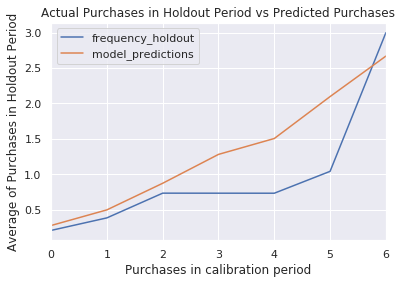

In [102]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

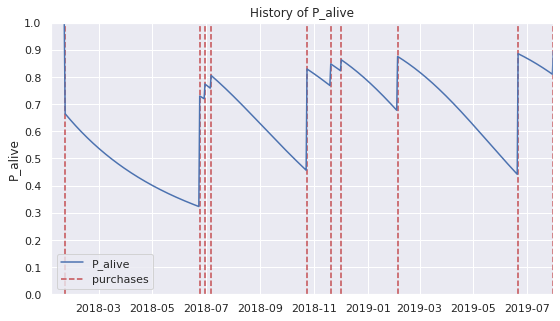

In [103]:
plt.figure(figsize=(9,5))
user = 'd4b3f8ddf91c4fbeb9b709eec30710c31c7643e5b5f647a87b66b262972bb09c' 
days_since_birth = 365
sp_trans = booked_df.loc[booked_df['user_id'] == user]
plot_history_alive(bgf, days_since_birth, sp_trans, 'latest_status_change_dt');

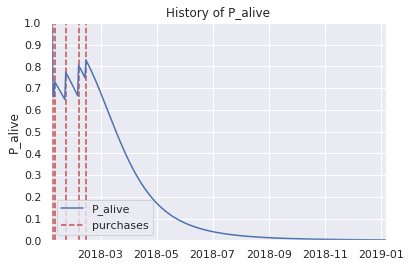

In [104]:
user = '22aec3ce1c62b59aa956d4ede63f5e660c2d457eabab8a70f128fc062c0d3305' 
days_since_birth = 365
sp_trans = booked_df.loc[booked_df['user_id'] == user]
plot_history_alive(bgf, days_since_birth, sp_trans, 'latest_status_change_dt')

In [105]:
returning_customers_summary = data[data['frequency']>0]

print(returning_customers_summary.head())

                                                    frequency  recency      T  \
user_id                                                                         
001a25f124e240f5372e8c73117c54bd1b1ae6339bf8641...        1.0     39.0  275.0   
00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc...        3.0    268.0  455.0   
00770c43298f4cd9ee3dfe37882825be327db3dca9affd9...        2.0    174.0  490.0   
00874310e86ae74c1b470ec0f766493ed2f8949bbc00471...        1.0      5.0  602.0   
00eaf2f44b992ddf993559d9f1cf2f22c56e4ba4e0c81a8...        1.0    210.0  432.0   

                                                    monetary_value  \
user_id                                                              
001a25f124e240f5372e8c73117c54bd1b1ae6339bf8641...           602.0   
00702b0d3e9ad967e0df6b9f062a5cf5b83524d10ae32bc...           459.0   
00770c43298f4cd9ee3dfe37882825be327db3dca9affd9...           152.0   
00874310e86ae74c1b470ec0f766493ed2f8949bbc00471...           412.0   
00eaf2f44b99

In [106]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.00000,-0.00446
frequency,-0.00446,1.00000


count    4596.000000
mean        0.778503
std         1.609312
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        26.000000
Name: frequency, dtype: float64
0.6303307223672759


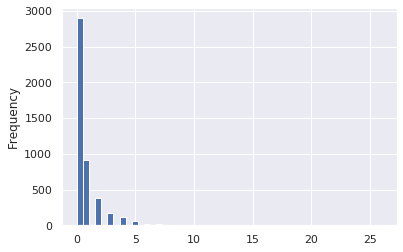

In [111]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))